## This notebook reviews the Cold Lake Blend case and plots up beaching volume

Two methods for exploring beaching volume and mass:
1. surface 3D concentration values at land points (mass = 3D concentration * volume = 8.4e08 kg, see In[10]) and 
2. 2D thickness values at land points (mass = oil thickness * area * density = 2.8e06, see In[13])

Take-away: Work in progress!  

I guessed on volume for (1), so that's something to consider.  My assumption was that the 3D concentration for the upper grid cell was calculated using a volume of 500 x 440 x 4 m3 per cell, which I then multiplied by the total number of cells with values (70). 

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.dates as mpd

# graphics packages
from salishsea_tools import viz_tools
import matplotlib.pyplot as plt

# used to toggle file paths between different computers
from sys import platform

In [2]:
# User inputs.  As set up now, darwin -> paths on Rachael's "shuga" laptop 
## The other paths are for Vicky's Ocean setup

if platform == 'darwin':
    bathy_dir = '/Users/rmueller/Data/SalishSeaCast/grid/'
    results_dir = '/Users/rmueller/Projects/MIDOSS/results/HeavySinker/CLB/'
    out_dir = '/Users/rmueller/Documents/Presentations/Graphics/MIDOSS/SOILED/Beaching/'
else:
    display('Error: Need to setup directory structure')
    
# Set to [1] if you want to print to file and [0] if not
print_to_file = 1

In [3]:
results_xr = xr.open_dataset(results_dir + 'Lagrangian_CLB_crude_TP_21nov2017_28nov2017_CLB.nc')
beachingtime = results_xr.Beaching_Time[:]
thickness2D = results_xr.Thickness_2D[:]
start_time = np.datetime64('2017-11-21T00:30:00')

In [4]:
# get array size to use for converting time into numeric values
[ny,nx] = beachingtime.shape
x_range = range(nx)
y_range = range(ny)

# convert beaching time to numeric value
display('Calculating beaching time')
beachingtime_asnum = np.array([[((np.datetime64(beachingtime.values[jj,ii]) - start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating beaching time'

In [5]:
# set locations of absent a beaching timescale to zero
beachingtime_asnum[beachingtime_asnum==0] = np.nan

# create a logical array of true "keepers" where beaching time scale is non-zero
keepers   = np.isreal(beachingtime_asnum)

# similarly, a logical array of wasteland garbage where beaching time scale is absent 
notkeepers = np.isnan(beachingtime_asnum)

In [6]:
# number of "keepers" grid cells
nbeached = 896*396 - np.sum(notkeepers==1)
nbeached

70

'dark_background'

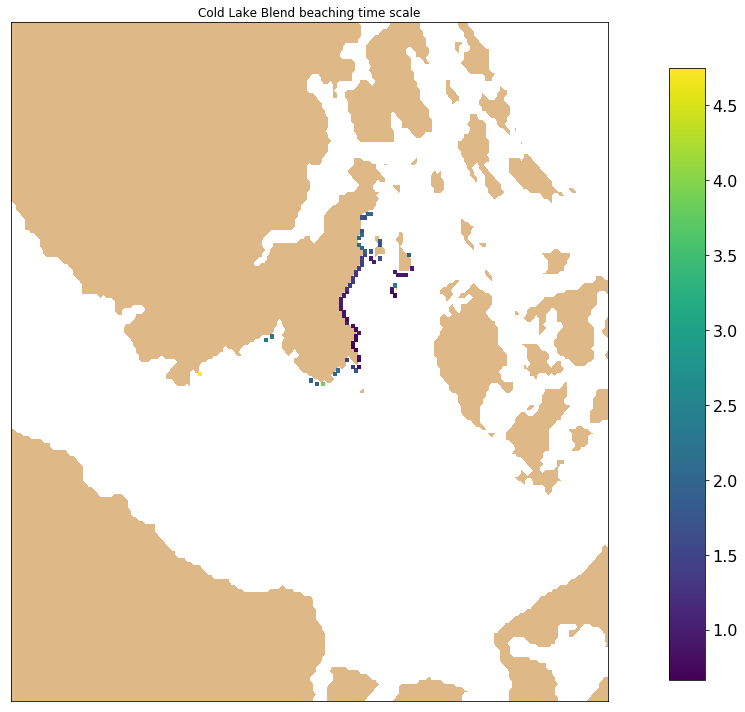

In [7]:
fig, axs = plt.subplots(1,1,figsize=(10,10))
# add land mask
viz_tools.plot_land_mask(axs,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
# add beaching time scales
mappable = axs.pcolormesh(beachingtime_asnum)
axs.set_title("Cold Lake Blend beaching time scale")

# make pretty(ier)
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)
viz_tools.set_aspect(axs)
axs.set_xlim(100,300) #change this to set x axis limits
axs.set_ylim(200,400) #change this to set y axis limits
    
plt.tight_layout();

#[left, bottom, width, height]
ax_cbar = fig.add_axes([1.,0.05,0.05,.85])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation='vertical')
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticklabels(str([0,1,2,3,4,5,6]))
#cbar.set_label(fontsize=24)
plt.style.available[23]

## plot up beached oil concentration

In [8]:
concentration3d = results_xr.OilConcentration_3D[:]
[nt,nz,ny,nx] = concentration3d.shape
concentration40end = concentration3d[nt-1,nz-1,:,:]
concentration0end = concentration3d[nt-1,0,:,:]


In [9]:
concentration40end = np.ones((ny,nx)) * np.nan
concentration40end = concentration3d[nt-1,nz-1,:,:].where(keepers).values

#~~~~~~~~~~   why is the below needed after "where(keepers)" is used? ~~~~~~~~~~~~~
concentration40end[concentration40end==0]=np.nan

# Add up all values for total concentration to compare with volume estimate
np.nansum(concentration40end[:])

13.644200000000001

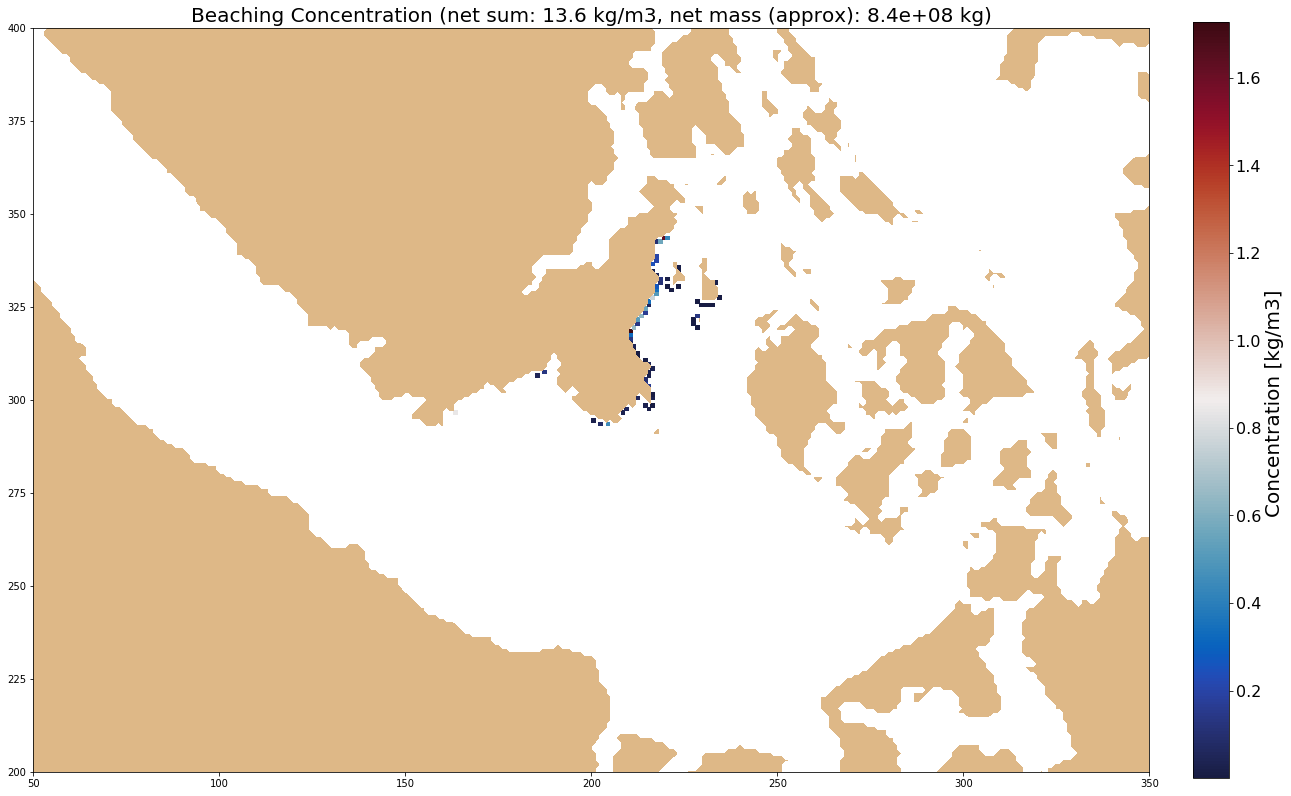

In [10]:
fs = 20
fig = plt.figure(figsize=(20,20))
ax_cbar = fig.add_axes([0.93, 0.24, 0.025, 0.525]) 
ax1 = fig.add_subplot(111)
mappable = ax1.pcolormesh(concentration40end, cmap = cm.cm.balance)
viz_tools.plot_land_mask(ax1,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
ax1.set_title('Beaching Concentration (net sum: ' + f'{np.nansum(concentration40end[:]):3.1f}' + ' kg/m3, net mass (approx): ' + 
              f'{nbeached * 500 * 440 * 4 * np.nansum(concentration40end[:]):3.1e}' + ' kg)', fontsize = fs)
ax1.set_ylim(200,400)
ax1.set_xlim(50,350)
ax1.set_aspect(aspect=1)
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation='vertical')
cbar.ax.tick_params(labelsize=16) 
cbar.set_label('Concentration [kg/m3] ', fontsize = fs);


## plotting beaching volume

### Using last time step of thickness 2D 

In [11]:
[nt,ny,nx] = thickness2D.shape
#beachingvolume = np.empty(thickness2D.shape)
#beachingvolume.shape

In [12]:
#beachingvolume = np.empty(thickness2D.shape)
beachingvolume = 500 * 440 * thickness2D[nt-1,:,:].where(keepers).values * 1e-6
beachingvolume[beachingvolume==0] = np.nan
#beachingtime_asnum[beachingtime_asnum==0] = np.nan
#beachingvolume = np.asarray([
#    thickness2D[it,:,:].where(keepers) for it in range(nt)])

In [13]:
total_volume = np.sum(500 * 440 * thickness2D[nt-1,:,:].where(keepers).values) * 1e-6
display(['total volume of beached oil: ' + f'{total_volume:5.1f}' + ' m^3'])
display(['total mass of beached oil: ' + f'{total_volume * 939:3.1e}' + ' kg'])

['total volume of beached oil: 2963.8 m^3']

['total mass of beached oil: 2.8e+06 kg']

'dark_background'

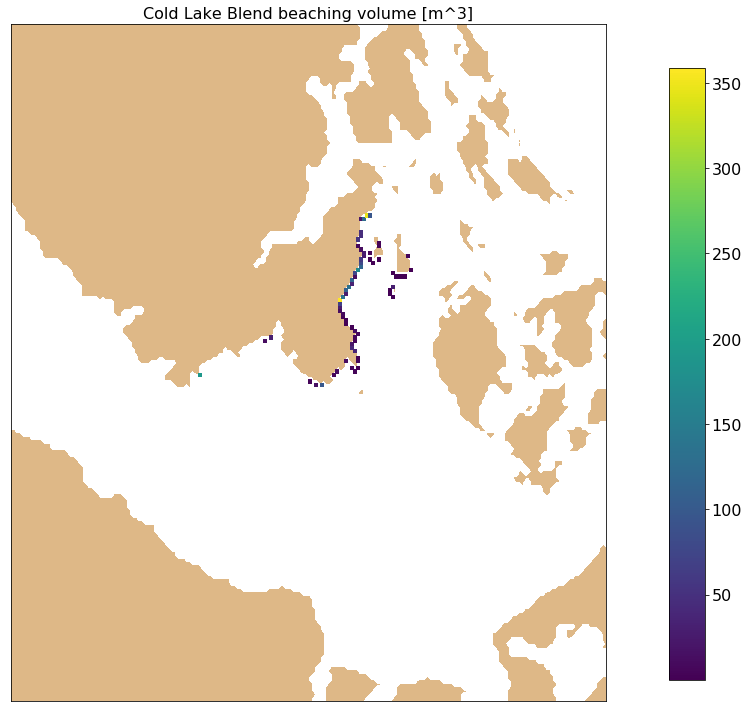

In [14]:
beachingvolume.shape
fig, axs = plt.subplots(1,1,figsize=(10,10))
# add land mask
viz_tools.plot_land_mask(axs,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
# add beaching time scales
mappable = axs.pcolormesh(beachingvolume)
axs.set_title("Cold Lake Blend beaching volume [m^3]", fontsize=16)

# make pretty(ier)
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)
viz_tools.set_aspect(axs)
axs.set_xlim(100,300) #change this to set x axis limits
axs.set_ylim(200,400) #change this to set y axis limits
    
plt.tight_layout();

#[left, bottom, width, height]
ax_cbar = fig.add_axes([1.,0.05,0.05,.85])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation='vertical')
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticklabels(str([0,1,2,3,4,5,6]))
#cbar.set_label(fontsize=24)
plt.style.available[23]

### Using beaching volume output

In [15]:
beachingvolume = results_xr.Beaching_Volume[:] # straight up 
beachingvolume

<xarray.DataArray 'Beaching_Volume' (grid_y: 896, grid_x: 396)>
[354816 values with dtype=datetime64[ns]]
Coordinates:
  * grid_y   (grid_y) int16 0 1 2 3 4 5 6 7 ... 888 889 890 891 892 893 894 895
  * grid_x   (grid_x) int16 0 1 2 3 4 5 6 7 ... 388 389 390 391 392 393 394 395
Attributes:
    standard_name:  Beaching_Volume
    long_name:      Beaching Volume

In [16]:
beachingvolume.values

array([['2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000', ...,
        '2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000'],
       ['2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000', ...,
        '2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000'],
       ['2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000', ...,
        '2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000'],
       ..., 
       ['2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000', ...,
        '2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000'],
       ['2017-11-21T00:30:00.000000000', '2

#### NOTE: Beaching volume values saved to output are datetimes, not volumes

### Compare Beached Volume from .sro file

In [17]:
with open(results_dir + 'resOilOutput.sro', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]
    header = all_data[4]
    
# Order header into list array by splitting up string
header_arr = []
header_arr = header.split(' ')
# Remove emtpy entries from list
header_arr = np.asarray([x for x in header_arr if x != ''])
header_arr

array(['Seconds', 'YY', 'MM', 'DD', 'hh', 'mm', 'ss', 'MassOil',
       'VolOilBeached', 'VolumeBeached', 'VolumeOil', 'Volume', 'Area',
       'TeoricalArea', 'Thickness', 'MEvaporated', 'VEvaporated',
       'FMEvaporated', 'MDispersed', 'VDispersed', 'FMDispersed',
       'MSedimented', 'VSedimented', 'FMSedimented', 'MDissolved',
       'VDissolved', 'FMDissolved', 'MChemDisp', 'VChemDisp', 'FMChemDisp',
       'MOilRecovered', 'VOilRecovered', 'FMOilRecovered', 'MWaterContent',
       'VWaterContent', 'Density', 'Viscosity', 'MBio', 'VBio', 'FMBio',
       'CharacteristicDiameter', 'P_Star', 'AnalyteMass1', 'AnalyteMass2',
       'AnalyteMass3', 'AnalyteMass4', 'AnalyteMass5', 'AnalyteBio1',
       'AnalyteBio2', 'AnalyteBio3', 'AnalyteBio4', 'AnalyteBio5'],
      dtype='<U22')

In [18]:
file_in = results_dir + 'resOilOutput.sro'
data2D = np.genfromtxt(file_in, skip_header=6, skip_footer=4)

# define structure of structured array
dtype = [('Header',(np.str_,22)),('Values', np.float64)]

# create index list for for-loop over columns
header_range = range(header_arr.size)
data_range = range(nrows)

# Assign 2D data and header strings to structured array
massbalance = np.array([[(header_arr[hdr_index], data2D[data_index, hdr_index]) for hdr_index in header_range] for data_index in data_range], dtype=dtype)
[data_len, ncols] = massbalance.shape

NameError: name 'nrows' is not defined

In [ ]:
i_voloilbeached = 8  # VolumeOilBeached = VolumeBeached
i_volumebeached = 9  
i_volumeoil     = 10 # VolumeOil = Volume
i_volume        = 11

VolOilBeached = data2D[range(data_len), i_voloilbeached]
VolumeBeached = data2D[range(data_len), i_volumebeached]
VolumeOil     = data2D[range(data_len), i_volumeoil]
Volume        = data2D[range(data_len), i_volume]

#plt.plot([data2D[range(191), data_index] for data_index in plot_data])
plt.plot(VolOilBeached+1000)
plt.plot(VolumeBeached+2000)
plt.plot(VolumeOil + 500)
plt.plot(Volume)
plt.ylabel('Volume Beached (assumed m^3)')
plt.xlabel('Time after oil release (hours) ')
plt.legend(['VolOilBeached', 'VolumeBeached','VolumeOil', 'Volume'])
#plt.savefig('VolumeBeached.png')

In [ ]:
#plt.plot([data2D[range(191), data_index] for data_index in plot_data])
plt.plot(VolOilBeached)
plt.plot(VolumeOil)
plt.ylabel('Volume Beached (assumed m^3)')
plt.xlabel('Time after oil release (hours) ')
plt.legend(['VolOilBeached', 'VolumeOil'])
plt.savefig('VolumeBeached.png')

In [ ]:
i_mevaporated = 15
i_mdispersed  = 18
i_mdissolved  = 24
i_mbio        = 37

#plt.plot([data2D[range(191), data_index] for data_index in plot_data])
plt.plot(data2D[range(data_len), i_mevaporated])
plt.plot(data2D[range(data_len), i_mdispersed])
plt.plot(data2D[range(data_len), i_mdissolved])
plt.plot(data2D[range(data_len), i_mbio])
plt.ylabel('Mass (Tonnes)')
plt.xlabel('Time after oil release (hours) ')
plt.title('Mass balance')
plt.legend(['Evaporated', 'Dispersed','Disolved','Biodegraded'])
plt.savefig('EvaporativeExposure_massbalance.png')

In [ ]:
i_density   = 35
#plt.plot([data2D[range(191), data_index] for data_index in plot_data])
plt.plot(data2D[range(data_len), i_density])
plt.ylabel('Density (kg/m^3)')
plt.xlabel('Time after oil release (hours) ')
plt.title('Density of Oil')
